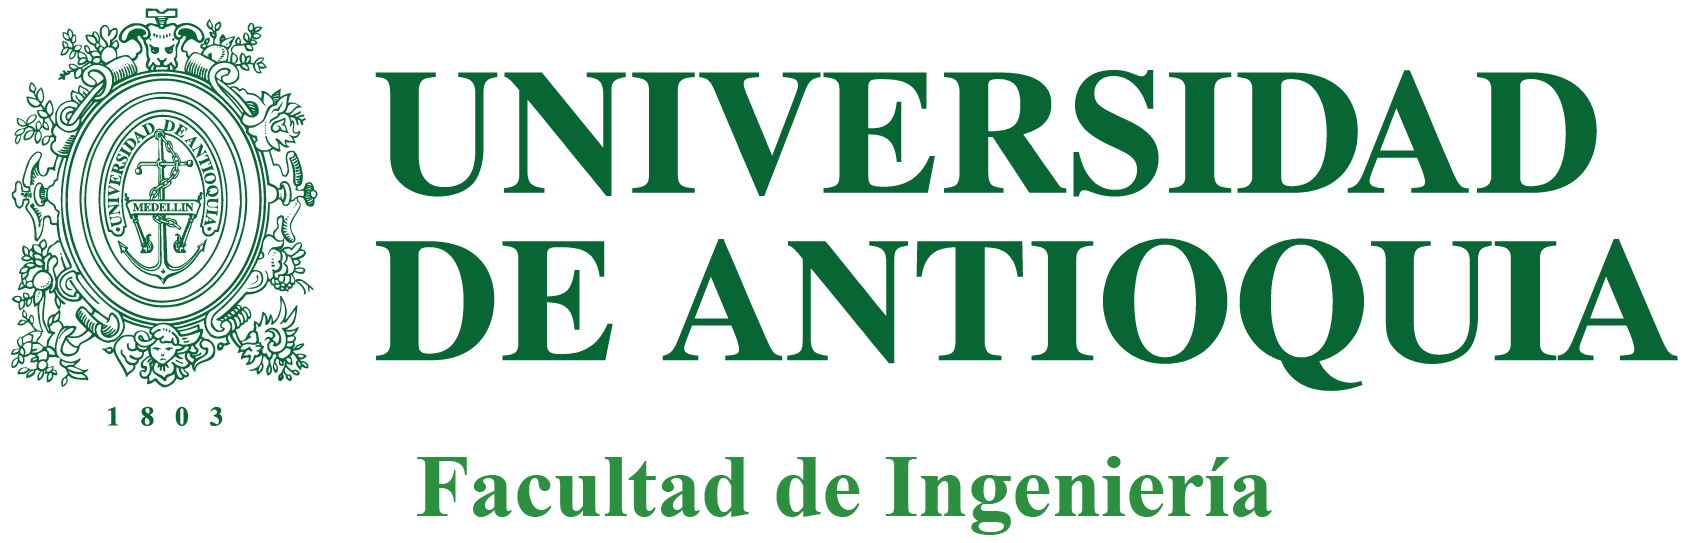


---------------
**Asignatura:** Tratamiento de Señales III

**Por:**

  - Juan Pablo Areiza
  - David Alexander Sánchez

**Profesor:** Hernán Felipe García Arias

**Facultad de Ingeniería**

**Departamento de Ingeniería Electrónica y Telecomunicaciones**

**Universidad de Antioquia**

**2023-2**

-------------
### Librerías

In [1]:
import os,random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, sys
%matplotlib inline

-------------------
# Reconocimiento de modulación mediante redes neuronales convolucionales (CNN)

## 1. Preprocesamiento de datos:


In [2]:
!gdown '1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K'

Downloading...
From: https://drive.google.com/uc?id=1Yuj_rq3EEITslOQ0AHEl2HKzDovMQH3K
To: /content/RML2016.10a_dict.pkl
100% 641M/641M [00:05<00:00, 127MB/s]


In [3]:
# Load the dataset ...
#  You will need to seperately download (radioml.com) or generate this file
with open("RML2016.10a_dict.pkl", 'rb') as f:
    Xd = pickle.load(f, encoding="latin1")

Los datos que se guardaron contenían una gran matriz de diccionario de Python. Las claves del diccionario fueron las combinaciones de tipo de [modulación](https://en.wikipedia.org/wiki/Phase-shift_keying) y relaciones señal-ruido (SNR) que fueron simuladas por GNU Radio para producir los datos. Hay 11 esquemas de modulación: 8 digitales y 3 analógicos. Se añadió ruido blanco gaussiano a cada señal proporcional a la potencia de la señal.

$$ \text{SNR in decibels} = 10 \times \log \left ( \frac{\text{signal power}}{\text{noise power}} \right ) $$

In [4]:
# Calculate modulations and signal-to-noise ratios contained in dataset
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])

In [5]:
print('These are the modulation schemes in the dataset: {}'.format(mods))
print('These are the signal to noise ratios in the dataset: {}'.format(snrs))

These are the modulation schemes in the dataset: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
These are the signal to noise ratios in the dataset: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


### Señales de radiofrecuencia (RF)

Una vez que hayamos especificado la clave del diccionario (por ejemplo, ['QAM64', 4] para modulación QAM64 @ 4 dB SNR), nos quedará la siguiente matriz.

In [6]:
np.shape(Xd['BPSK', -18])

(1000, 2, 128)

+ La segunda dimensión representa los dos componentes ([I & Q](https://youtu.be/h_7d-m1ehoY)) de la señal de RF.
+ La tercera dimensión representa las 128 muestras en el tiempo (1 MHz, por lo que 1 $\mu$s por índice)
+ La primera dimensión representa las 1000 ventanas muestreadas (cada ventana tiene las 128 muestras I y Q)


$$\text{Modulated Carrier RF} = I \cos(2\pi ft) + Q \sin(2 \pi ft)$$

In [7]:
'''
Compute the original RF signal from the I & Q components.
'''
def reconstructSignal(s):
    I = s[0,:]   # I component
    Q = s[1,:]   # Q component
    n = len(I)   # number of samples
    f = 1e6     # Carrier frequency
    return I*np.cos(2*np.pi*f*np.arange(n)) + Q*np.sin(2*np.pi*f*np.arange(n))

### Tracemos algunos de los datos sin procesar.

Así que elegiremos un 8PSK (con SNR @ 18 dB), un PAM4 (con SNR @ 6 dB), un BPSK (con SNR @ 0 dB) y un QAM64 (con SNR @ -12 dB).

Observe cómo la señal queda enterrada en el ruido a medida que disminuye la SNR.

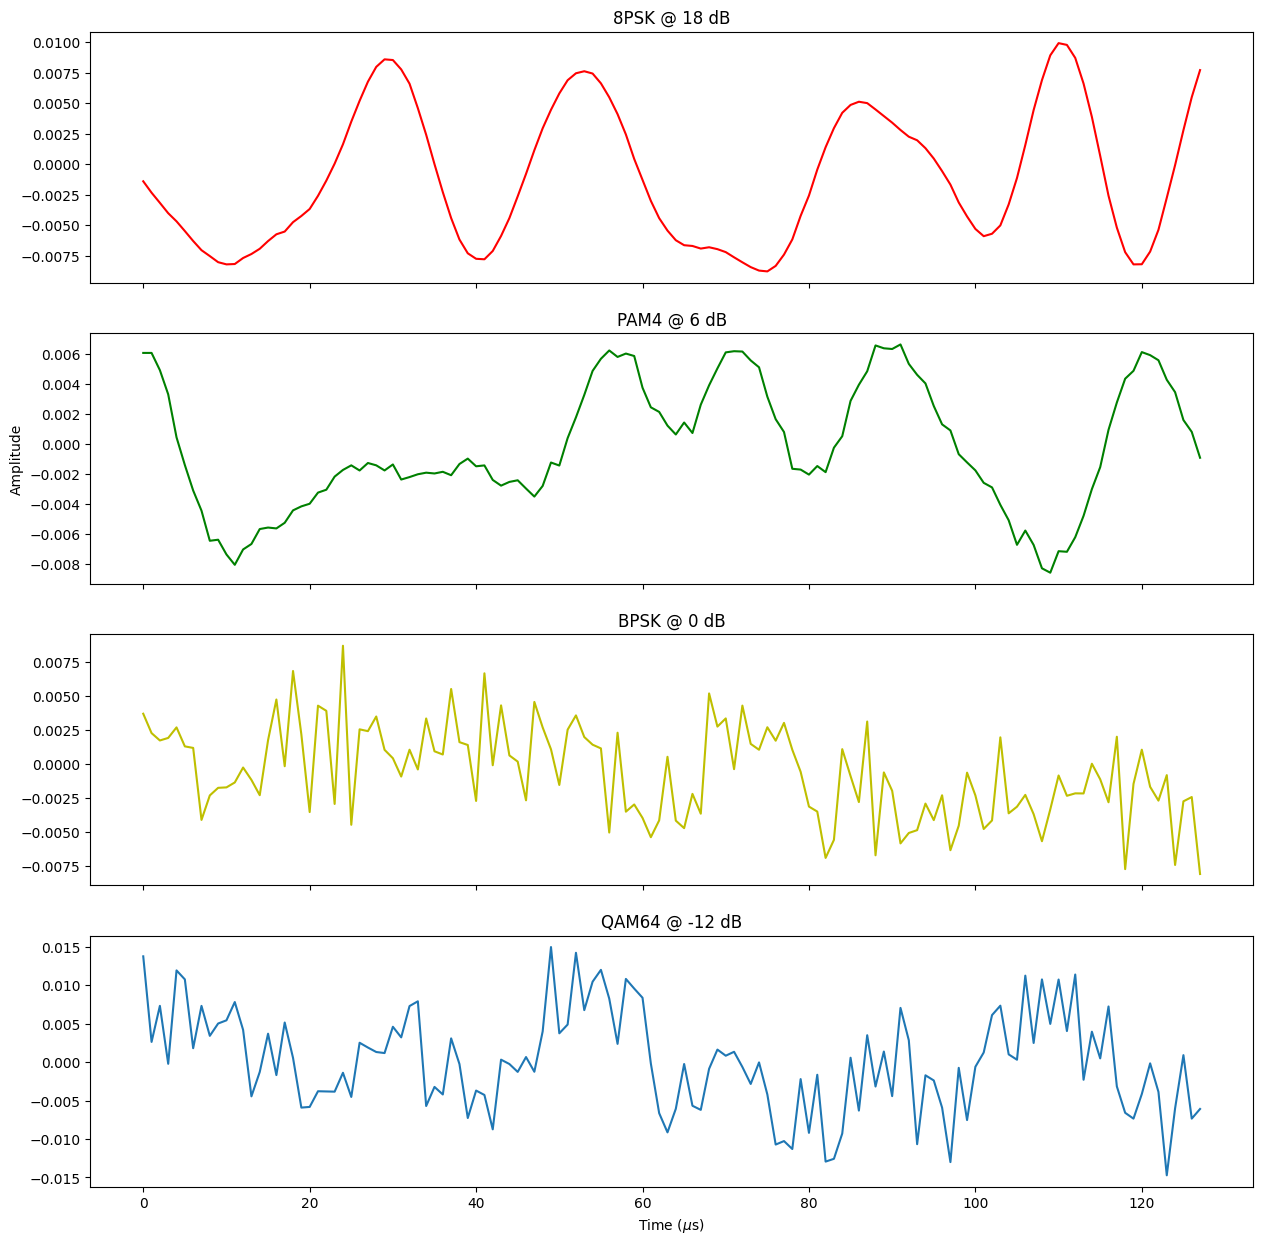

In [8]:
# Plot some of the data
nFigs = 4

plt.figure(figsize=(15, 15))

ax1 = plt.subplot(nFigs, 1, 1);
plt.plot(reconstructSignal(Xd['8PSK', 18][2,:,:]), color='r');
plt.title('8PSK @ 18 dB')

ax2 = plt.subplot(nFigs, 1, 2, sharex=ax1);
plt.plot(reconstructSignal(Xd['PAM4', 6][99,:,:]), color='g');
plt.title('PAM4 @ 6 dB')

plt.ylabel('Amplitude');

ax3 = plt.subplot(nFigs, 1, 3, sharex=ax1)
plt.plot(reconstructSignal(Xd['BPSK', 0][456,:,:]), color='y');
plt.title('BPSK @ 0 dB')

ax4 = plt.subplot(nFigs, 1, 4, sharex=ax1)
plt.plot(reconstructSignal(Xd['QAM64', -12][32,:,:]));
plt.title('QAM64 @ -12 dB')

# We only need to show the xticks on the bottom subplot
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.xlabel(r'Time ($\mu$s)');

### Ahora necesitamos agregar toda la modulación, SNR, muestras, canales y puntos de tiempo en una gran matriz para pasar a nuestra red neuronal.

Entonces habrá 220.000 muestras. Cada muestra es de 2 x 128. Los 2 son los canales I y Q. Las 128 son las 128 muestras de tiempo de la forma de onda (muestreadas a 1 MHz).

In [9]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [10]:
np.shape(X)

(220000, 2, 128)

### Agregar ruido al conjunto de datos

Agreguemos 2 canales de ruido gaussiano aleatorio para ver si podemos darle a la red la opción de elegir si no puede decidir entre las modulaciones verdaderas.

In [11]:
numNoiseSamples = 20000 # Add 20,000 samples of just Gaussian noise
for i in range(numNoiseSamples):
    lbl.append(['Noise', snrs[i%len(snrs)]])

mods.append('Noise')
X_noise = np.random.normal(0, 0.01, [numNoiseSamples, 2, 128])
X = np.concatenate((X, X_noise))  # Add noise to the end of the data

### Normalización

In [12]:
# Normalize each sample to range [0, 1]
X_normalized = (X - np.min(X, axis=2, keepdims=True)) / (np.max(X, axis=2, keepdims=True) - np.min(X, axis=2, keepdims=True))

### Reshape para la capa 2D convolucional

In [13]:
# Cambiar la forma de los datos para que sean compatibles con la CNN
# La CNN espera una entrada tridimensional (altura, anchura, canales)
# En este caso, los datos son bidimensionales, por lo que necesitamos agregar una dimensión extra
X_reshape = np.expand_dims(X_normalized, axis=-1)

In [14]:
print(X_reshape.shape)

(240000, 2, 128, 1)


## 2. Arquitectura del modelo CNN:


[Keras](https://keras.io/) es una abstracción de Python que le permite definir una red neuronal y codificarla automáticamente para bibliotecas de aprendizaje profundo (actualmente DeepLearning4j, TensorFlow y Theano). Simplemente le dice a Keras cuántas capas hay en el modelo de red y define cómo se ven esas capas. Keras se encarga de convertirlo en algo que TensorFlow y Theano puedan usar. Por lo tanto, es excelente para la experimentación de desarrollo rápido con redes neuronales. Puede construir cosas rápidamente y modificar rápidamente redes neuronales.

In [43]:
from tensorflow import keras
from keras.utils import to_categorical
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from keras.optimizers import Adam
#from tensorflow.keras.optimizers import adam

CNN implemented

In [16]:
# Define the model
model1 = models.Sequential()

# Reshape the input
model1.add(Reshape((2, 128, 1), input_shape=(2, 128)))

# 2D Convolutional layers
model1.add(ZeroPadding2D(padding=(0, 4)))
model1.add(Conv2D(filters=50, kernel_size=(2, 8), activation='relu'))
model1.add(MaxPooling2D(pool_size=(1, 2)))
model1.add(Conv2D(filters=50, kernel_size=(1, 8), activation='relu'))
model1.add(MaxPooling2D(pool_size=(1, 2)))
model1.add(Conv2D(filters=50, kernel_size=(1, 4), activation='relu'))
model1.add(Dropout(rate=0.6))
model1.add(MaxPooling2D(pool_size=(1, 2)))
model1.add(Flatten())

# Fully connected layers
model1.add(Dense(70, activation='selu'))
model1.add(Dense(12, activation='softmax'))

# Print the model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 2, 136, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 1, 129, 50)        850       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 64, 50)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 57, 50)         20050     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 1, 28, 50)         0

In [45]:
# Set dropout rate
dr = 0.5

# Build the CNN model
model2 = models.Sequential()
model2.add(Reshape((2, 128, 1), input_shape=(2, 128)))

model2.add(Conv2D(32, kernel_size=(2, 8), strides=(1, 1), padding='valid', name='conv1', activation='relu'))
model2.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1), padding='valid', name='conv2', activation='relu'))
model2.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1), padding='valid', name='conv3', activation='relu'))

model2.add(Flatten())

model2.add(Dense(512, name='dense1', activation='relu'))
model2.add(Dropout(dr, name='dropout_1'))
model2.add(Dense(256, name='dense2', activation='relu'))
model2.add(Dropout(dr, name='dropout_2'))
model2.add(Dense(12, name='dense3'))
model2.add(Activation('softmax', name='activation_1'))

model2.add(Reshape((12,), name='reshape_2'))

# Utilizamos el optimizador Adam para un mejor rendimiento
optimizer = Adam(lr=0.001)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 2, 128, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 1, 121, 32)        544       
                                                                 
 conv2 (Conv2D)              (None, 1, 119, 64)        6208      
                                                                 
 conv3 (Conv2D)              (None, 1, 117, 128)       24704     
                                                                 
 flatten_5 (Flatten)         (None, 14976)             0         
                                                                 
 dense1 (Dense)              (None, 512)               7668224   
                                                                 
 dropout_1 (Dropout)         (None, 512)              

In [46]:
model1.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model2.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## 3. Entrenamiento:


### Ahora dividamos aleatoriamente el conjunto de datos en un grupo de entrenamiento y un grupo de prueba.

El grupo de entrenamiento se utilizará para calcular los pesos de la red neuronal. El grupo de prueba se utilizará para evaluar (validar) qué tan bien se generalizan esos pesos a nuevos datos (es decir, qué tan bien debería funcionar nuestra red neuronal en la naturaleza).

Nuestro primer paso es [One Hot Encode](https://en.wikipedia.org/wiki/One-hot). Suena mal, pero es un procedimiento realmente sencillo. Básicamente, la computadora no entiende letras; sólo puede utilizar números. Por lo tanto, no tiene idea de a qué se refieren '8PSK' o 'WBFM' y no tiene forma de entrenar un modelo para que se ajuste a esas etiquetas. Ahora podríamos simplemente asignar un número a cada modulación (por ejemplo, 1 = '8PSK', 2 = 'AM-DSB', 3 = 'PAM4', etc.). Sin embargo, la codificación one-hot nos facilita calcular qué tan cerca está la salida de nuestra red neuronal (es decir, la predicción) del valor verdadero (esperado).

Para la codificación one-hot simplemente declaramos un vector que es tan grande como el conjunto de modulaciones únicas. Entonces, si tenemos 11 modulaciones, declaramos un vector de tamaño 1 x 11. La matriz es 0 en todas partes excepto en la modulación que se representa. Por ejemplo,

+  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
+  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
+  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
  
Entonces, el elemento más a la izquierda codifica '8PSK' y el más a la derecha codifica 'WBFM'. El posicionamiento es arbitrario. Simplemente tiene que aplicarse de forma coherente al conjunto de datos.

Una vez que hayamos codificado One Hot, podremos comparar qué tan cerca llega la salida de nuestra red neuronal (es decir, la predicción) a la modulación verdadera. Esta medida de "cercanía" se calcula normalmente mediante entropía cruzada (Shannon). Hay un excelente [video aquí] (https://www.youtube.com/watch?v=tRsSi_sqXjI).

$$ \text{cross entropy} = - \sum_i{L_i \log{S_i}}$$

dónde
+ $i$ pasa de 1 al número de modulaciones
+ $L_i$ es la etiqueta única para esa muestra en esa modulación
+ $S_i$ es la predicción de la red neuronal para esa muestra en esa modulación

Por ejemplo, si nuestra red neuronal predice 3 clases con las siguientes probabilidades:

$$\begin{bmatrix}0.2\\0.7\\0.1 \end{bmatrix}$$

y la muestra real tiene la codificación one-hot de:

$$\begin{bmatrix}0\\1\\0\end{bmatrix}$$

Entonces nuestra entropía cruzada es:
$$ - [ 0 \times \log(0.2) + 1 \times \log(0.7) + 0 \times \log(0.1) ] = \log(0.7) = 0.155$$

Si la predicción es perfecta, entonces la entropía cruzada es $1 \times \log(1) = 0$

In [19]:
from sklearn.preprocessing import LabelBinarizer

lbl = np.array(lbl) # Convert from list to numpy array (for speed)

# This will encode the labels into a binary array.
# This is referred to as One-Hot.
# Each element of the array is either 1 or 0.
# The position of the element refers to which type of modulation.
# So if there are 11 modulation types, then the
# array is length 11.
# e.g.  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] codes '8PSK'
#       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] codes 'AM-DSB'
#       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] codes 'WBFM'
# We'll use this to compare the output of the neural network
# and help train the model to give the lowest error (in this case
# the cost will be the cross-entropy).
y_encoded = LabelBinarizer().fit_transform(lbl[:,0])

print(y_encoded.shape)

(240000, 12)


In [20]:
y_encoded[-10:]

array([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

### Dividir en un conjunto de entrenamiento y prueba

Es crucial que dividamos los datos en al menos 2 conjuntos. Se utilizará un conjunto (llamado conjunto de entrenamiento) para entrenar la red neuronal. Es decir, los pesos de la red neuronal se ajustarán para realizar la mejor predicción posible de los datos de entrenamiento. Sin embargo, si nos detuviéramos ahí, entonces tendríamos un modelo que fuera bueno para predecir cosas cuyas respuestas ya conocía. Queremos asegurarnos de que el modelo pueda predecir cosas que nunca antes había visto. Por lo tanto, guardamos algunos datos (generalmente entre 1/4 y 1/3) para probar si la red neuronal entrenada puede ser tan precisa en datos que nunca ha visto.

La mayoría de los kits de herramientas de aprendizaje automático decentes contienen un método para dividir aleatoriamente sus datos en estos dos conjuntos. Normalmente usamos el de sklearn (train_test_split). Sin embargo, queremos realizar un seguimiento de los índices para poder obtener también las SNR al final. Entonces usaremos una matriz aleatoria para dividir los dos grupos.

In [21]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.7)

# Now get a list of random indicies to sample for the training set
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# Testing set is whatever indicies are left over
test_idx = list(set(range(0,n_examples))-set(train_idx))

# Now split up the data by the random indicies
X_train = X[train_idx]
X_test =  X[test_idx]
Y_train = y_encoded[train_idx]
Y_test = y_encoded[test_idx]

In [22]:
print('Training set is {}'.format(np.shape(X_train)))
print('Test set is {}'.format(np.shape(X_test)))

Training set is (168000, 2, 128)
Test set is (72000, 2, 128)


In [23]:
in_shp = list(X_train.shape[1:])   # This is the input shape of 2 channels x 128 time samples
print(X_train.shape, in_shp)
classes = mods
print(classes)

(168000, 2, 128) [2, 128]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM', 'Noise']


### Entrenar el modelo

`ModelCheckpoint` y `EarlyStopping` se utilizan para monitorear el entrenamiento y evitar el sobreajuste

In [24]:
# Set up some params
nb_epoch = 200     # number of epochs to train on
batch_size = 1024  # training batch size

In [47]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = './'
modelWeightsFile = filepath + 'PESOS_TSIII.wts.h5'  # Save the model weights to this file

history = model2.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(modelWeightsFile, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    ])

# we re-load the best weights once training is finished
model2.load_weights(modelWeightsFile)

Epoch 1/200

Epoch 1: val_loss improved from inf to 1.87707, saving model to ./PESOS_TSIII.wts.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


165/165 - 9s - loss: 2.0988 - accuracy: 0.2287 - val_loss: 1.8771 - val_accuracy: 0.3287 - 9s/epoch - 53ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 1.87707
165/165 - 6s - loss: 1.8584 - accuracy: 0.3120 - val_loss: 2.1021 - val_accuracy: 0.2135 - 6s/epoch - 34ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.87707 to 1.65805, saving model to ./PESOS_TSIII.wts.h5
165/165 - 6s - loss: 1.9386 - accuracy: 0.2998 - val_loss: 1.6580 - val_accuracy: 0.3655 - 6s/epoch - 34ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.65805 to 1.53333, saving model to ./PESOS_TSIII.wts.h5
165/165 - 6s - loss: 1.6549 - accuracy: 0.3784 - val_loss: 1.5333 - val_accuracy: 0.4230 - 6s/epoch - 35ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 1.53333
165/165 - 5s - loss: 1.5436 - accuracy: 0.4187 - val_loss: 1.5933 - val_accuracy: 0.4020 - 5s/epoch - 30ms/step
Epoch 6/200

Epoch 6: val_loss improved from 1.53333 to 1.42316, saving model to ./PESOS_TSIII.wts.h5
165/165 - 6s -

## 4. Evaluación:


In [48]:
from sklearn.metrics import classification_report
# Use the model to predict
y_pred = model2.predict(X_test)

# Convert predictions classes to one-hot vectors
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert validation observations to one-hot vectors
y_true = np.argmax(Y_test, axis=1)

# Use sklearn to compute accuracy and confusion matrix
class_report = classification_report(y_true, y_pred_classes, target_names=classes)

# Print the modified classification report with classes as the first column
print(f"{'Classes':<12} {class_report}")

2250/2250 [==============================] - 5s 2ms/step
Classes                    precision    recall  f1-score   support

        8PSK       0.63      0.49      0.55      5957
      AM-DSB       0.54      0.68      0.60      5852
      AM-SSB       0.26      0.94      0.41      5932
        BPSK       0.87      0.58      0.69      6051
       CPFSK       0.78      0.62      0.69      5963
        GFSK       0.79      0.62      0.70      6022
        PAM4       1.00      1.00      1.00      6125
       QAM16       0.85      0.68      0.76      5991
       QAM64       0.37      0.10      0.16      5906
        QPSK       0.53      0.71      0.61      6029
        WBFM       0.80      0.40      0.53      6072
       Noise       0.77      0.18      0.30      6100

    accuracy                           0.58     72000
   macro avg       0.68      0.58      0.58     72000
weighted avg       0.68      0.58      0.58     72000



## 5. Visualización:


### Curvas de pérdida

Las curvas de pérdidas nos muestran qué tan bien fue el entrenamiento. También nos permiten detectar el sobreentrenamiento del modelo. Si el modelo está sobreentrenado, es posible que no se generalice bien. A menudo, en un modelo sobreentrenado, la pérdida de entrenamiento (error) disminuirá continuamente mientras que la validación (error de prueba) disminuirá y luego comenzará a aumentar nuevamente con sucesivas épocas de entrenamiento.

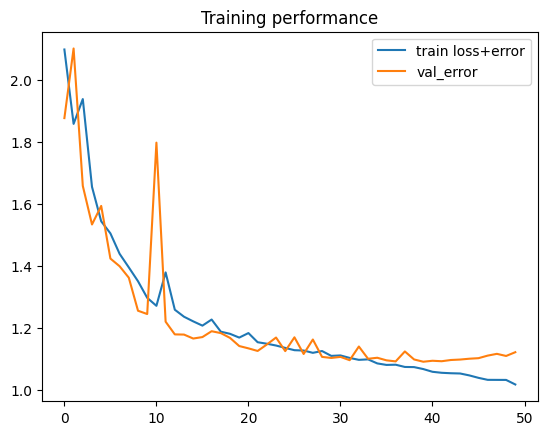

In [49]:
# Show loss curves
plt.figure();
plt.title('Training performance');
plt.plot(history.epoch, history.history['loss'], label='train loss+error');
plt.plot(history.epoch, history.history['val_loss'], label='val_error');
plt.legend();

### Matriz de confusión

Una matriz de confusión es una excelente manera de ver dónde tuvo problemas el modelo (red neuronal). Traza el número de veces que el modelo predijo una modulación versus la modulación real (predicha versus verdadera).

In [50]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

71/71 [==============================] - 0s 4ms/step


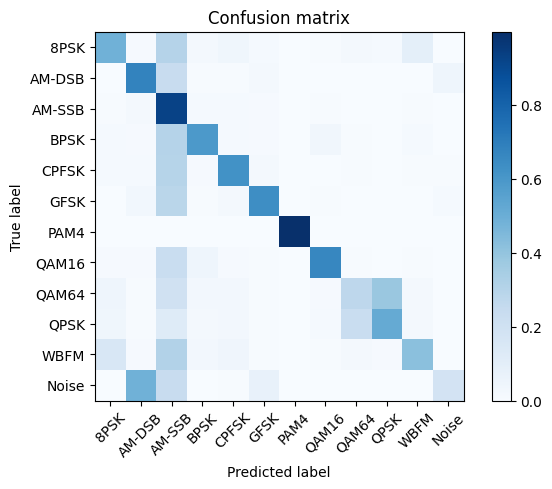

In [51]:
# Plot confusion matrix
test_Y_hat = model1.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

Evaluación del modelo en términos de $SNR$ y su precisión para cada modulación

4/4 [==============================] - 0s 5ms/step
Overall Accuracy for SNR -20: 0.16792400111763062
4/4 [==============================] - 0s 5ms/step
Overall Accuracy for SNR -18: 0.17446690667405151
4/4 [==============================] - 0s 5ms/step
Overall Accuracy for SNR -16: 0.1721781907625034
4/4 [==============================] - 0s 5ms/step
Overall Accuracy for SNR -14: 0.17798013245033112
4/4 [==============================] - 0s 5ms/step
Overall Accuracy for SNR -12: 0.21933187294633077
4/4 [==============================] - 0s 5ms/step
Overall Accuracy for SNR -10: 0.26695604991861094
4/4 [==============================] - 0s 5ms/step
Overall Accuracy for SNR -8: 0.39920836867401754
4/4 [==============================] - 0s 6ms/step
Overall Accuracy for SNR -6: 0.5396025748670585
4/4 [==============================] - 0s 6ms/step
Overall Accuracy for SNR -4: 0.6581077309517165
4/4 [==============================] - 0s 5ms/step
Overall Accuracy for SNR -2: 0.720077220077220

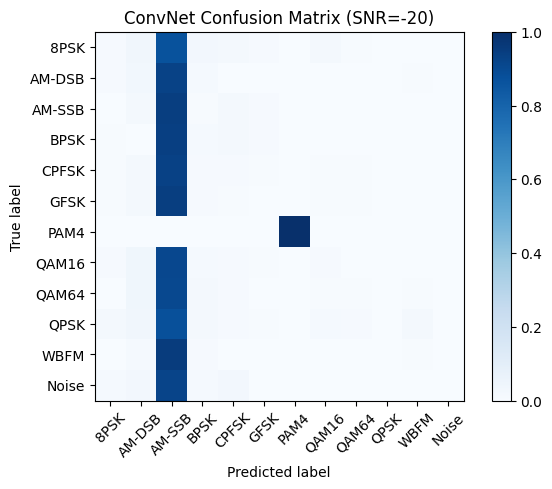

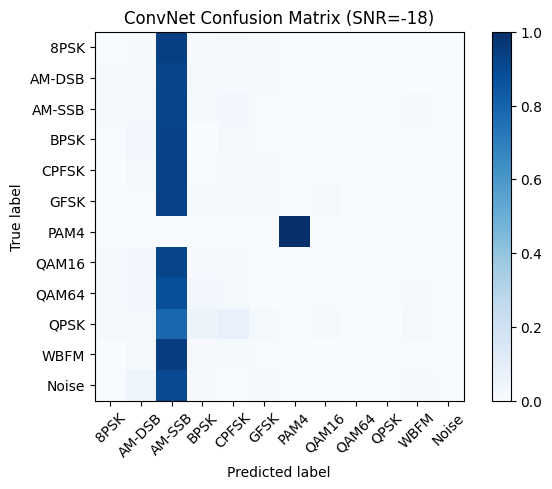

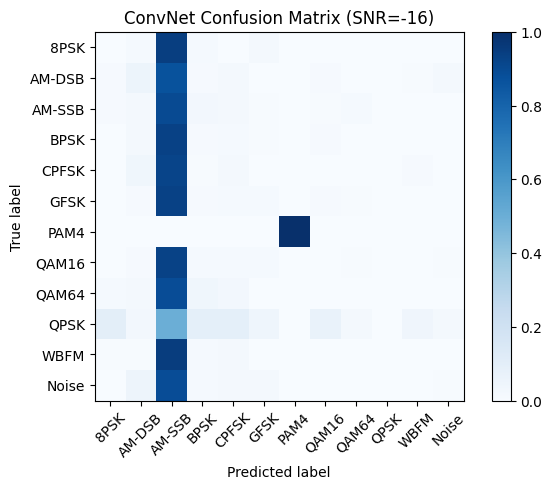

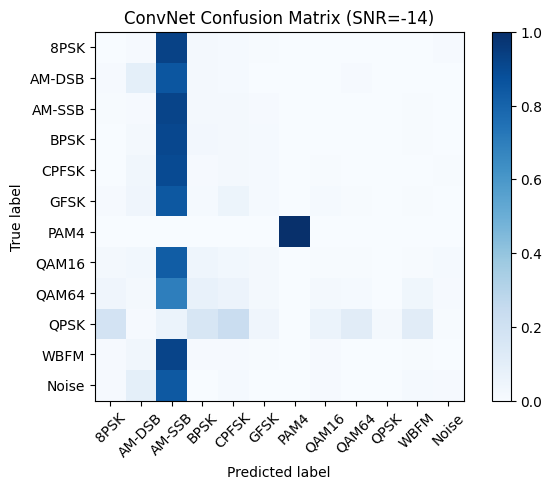

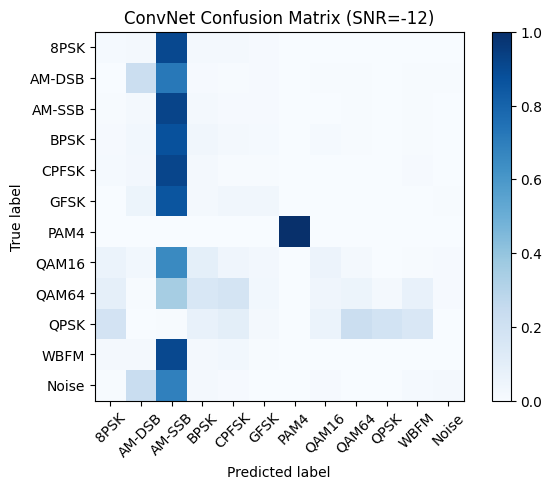

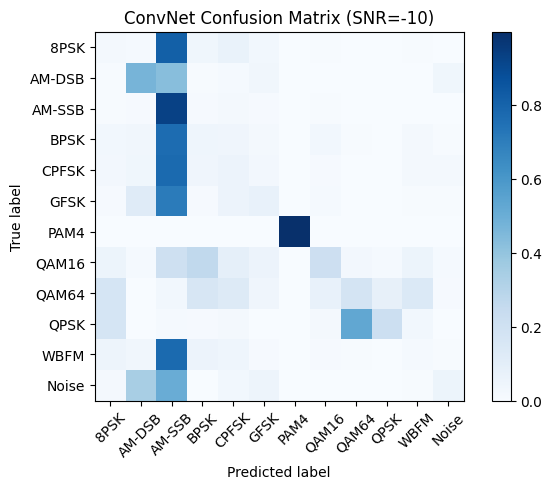

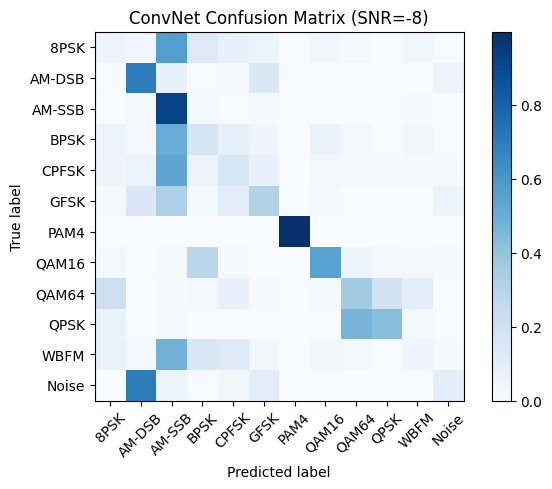

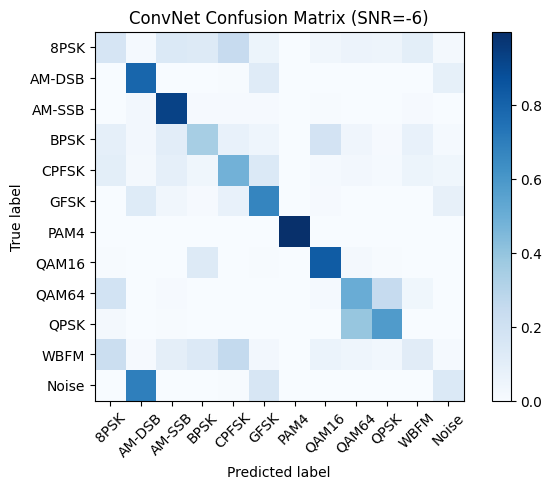

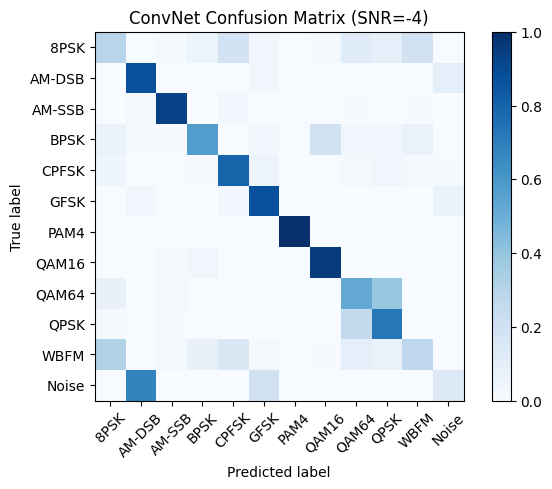

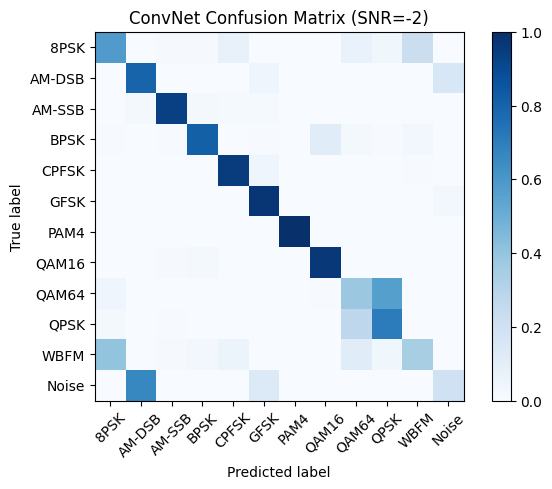

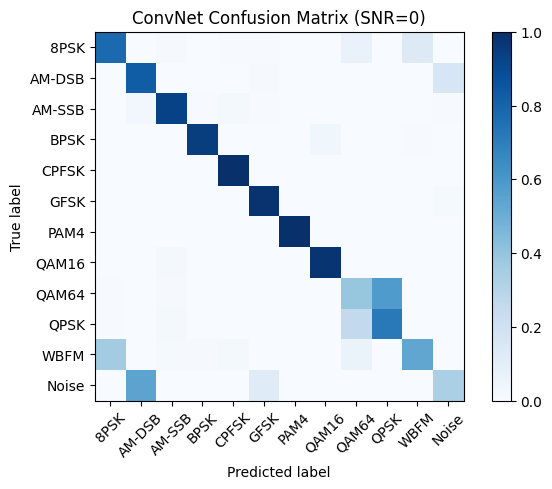

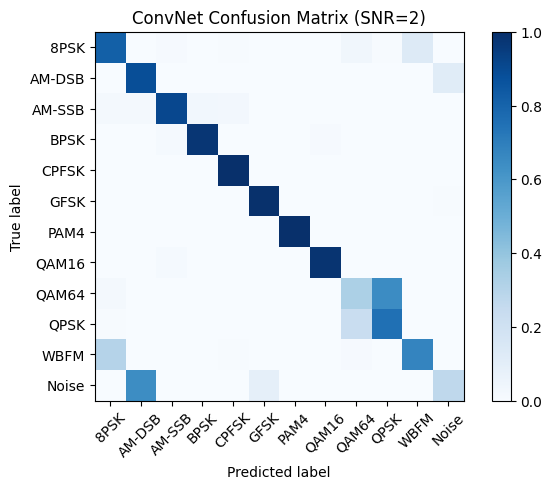

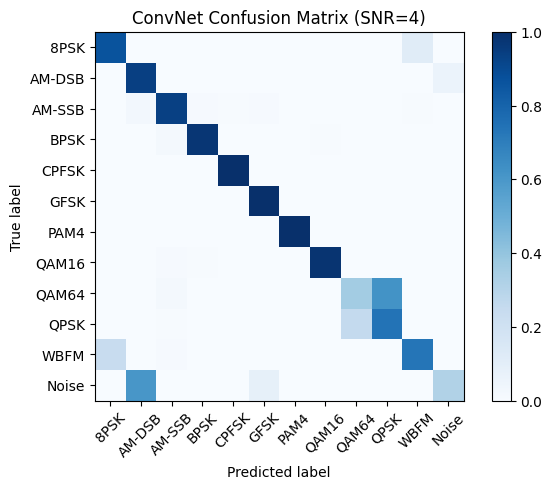

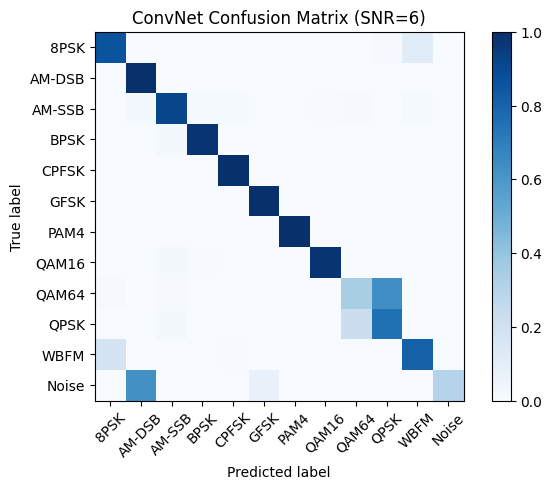

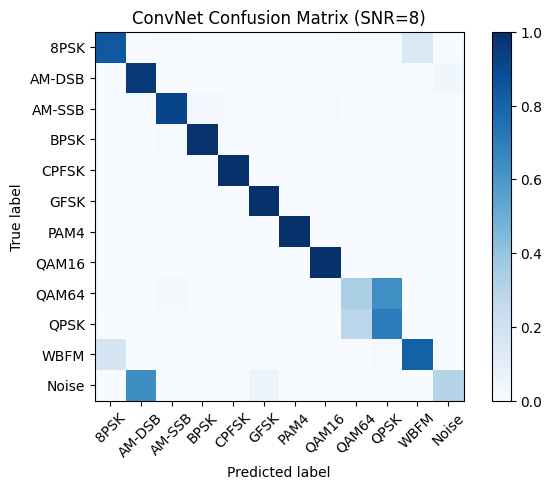

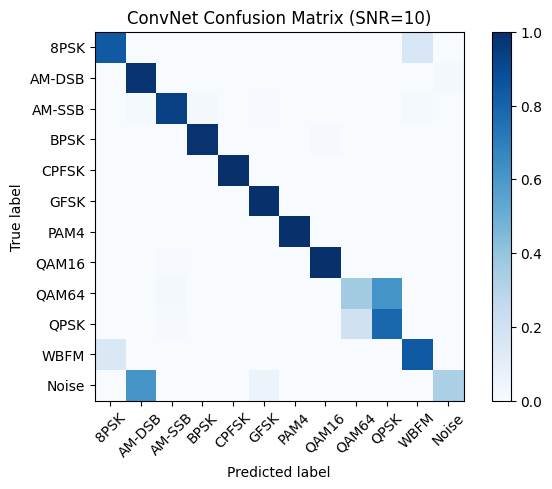

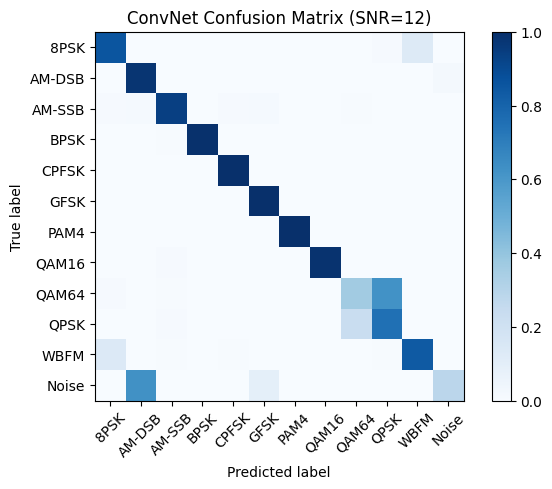

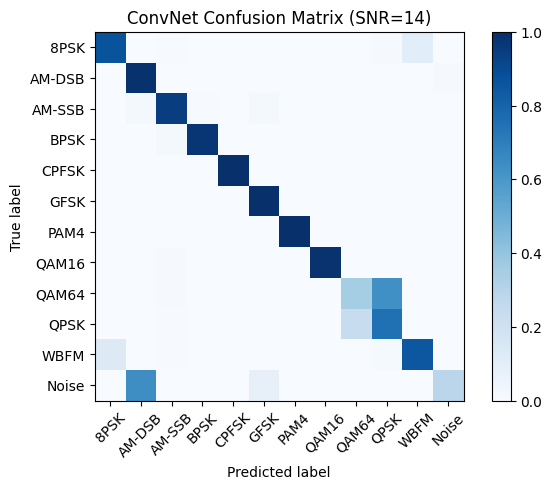

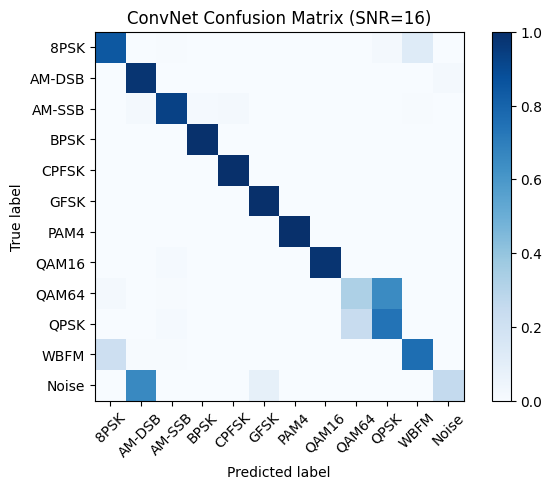

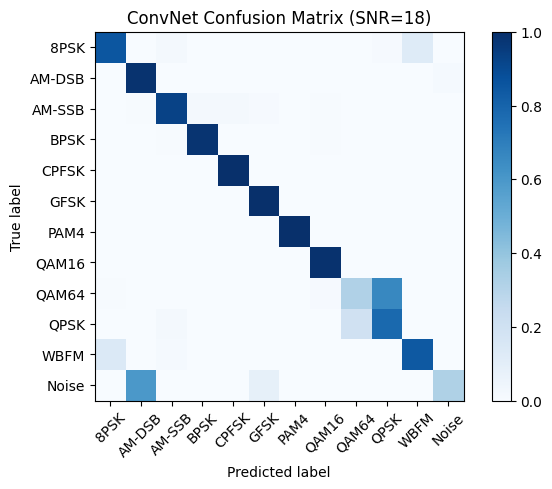

In [52]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: int(lbl[x][1]), test_idx)
    test_S = []
    for i in test_SNRs:
      test_S.append(i)
    test_S = np.array(test_S)
    test_X_i = X_test[np.where(test_S == snr)]
    test_Y_i = Y_test[np.where(test_S == snr)]

    # estimate classes
    test_Y_i_hat = model1.predict(test_X_i, batch_size=batch_size)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy for SNR {}: {}".format(snr, cor / (cor+ncor)))
    acc[snr] = 1.0*cor/(cor+ncor)

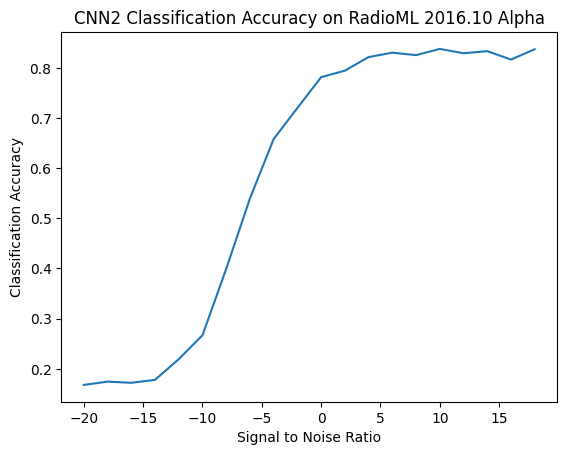

In [53]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)));
plt.xlabel("Signal to Noise Ratio");
plt.ylabel("Classification Accuracy");
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha");

## 6. Análisis

## 7. Conclusiones